In [24]:
import pandas as pd
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib

pd.set_option('display.max_columns', 200)


data = {}


def load_json(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        return json.load(file)


def preprocess_token_data(data: dict) -> pd.DataFrame:
    records = []
    for mint, token in data.items():
        for price_change in token.get("marketCapHistory", []):
            timestamp = price_change.get("timestamp")
            if timestamp > 10 * 10:
                timestamp = timestamp / 1000
            records.append({
                "timestamp": timestamp,
                "marketCap": price_change.get("marketCap", 0),
                "symbol": token.get("symbol", "Unknown"),
                "volume": token.get("volume", 0),
                "numHolders": token.get("numHolders", 0),
                "sniperCount": token.get("sniperCount", 0),
                "progress": token.get("progress", 0),
                "buySellRatio": token.get("buySellRatio", 0),
                "liquidity": token.get("liquidity", 0),
                "volatility": token.get("volatility", 0)
            })

        for neo in token.get("Neo", []):
            records.append({
                "symbol": token.get("symbol", "Unknown"),
                "holderCounts": neo.get("holderCounts", 0),
                "tagsCount": neo.get("tagsCount", 0),
                "devHoldingSupplyPerc": neo.get("devHoldingSupplyPerc", 0),
                "insiderWalletsSupplyPerc": neo.get("insiderWalletsSupplyPerc", 0)
            })

        for trades in token.get("trades", []):
            records.append({
                "timestamp": trades.get("timestamp"),
                "symbol": token.get("symbol", "Unknown"),
                "solAmount": trades.get("solAmount", 0),
                "isBuy": trades.get("isBuy", 0),
            })

    return pd.DataFrame(records)


files = [
    'data/coiny_bez_limitu6.json',
    'data/coiny_bez_limitu7.json',
    'data/coiny_bez_limitu8.json',
    'data/coiny_bez_limitu9.json',
    'data/coiny_bez_limitu10.json',
    'data/coiny_bez_limitu11.json',
]

for file in files:
    data.update(load_json(file))

df = preprocess_token_data(data)
df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,holderCounts,tagsCount,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy
0,1.738860e+06,7887.522187,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.738860e+06,7892.808009,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.738860e+09,7885.040000,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.738860e+06,7935.138594,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.738860e+06,7973.608513,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409964,1.739034e+09,NaN,OFI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000e+09,True
409965,1.739034e+06,5432.958982,LCSE,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
409966,1.739034e+09,NaN,LCSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.005390e+07,True
409967,1.739034e+06,5476.591540,ice,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Converting data and creating new features
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.sort_values(['symbol', 'timestamp'], inplace=True)

df['marketCap_change'] = df.groupby('symbol')['marketCap'].pct_change().fillna(0)
df['marketCap_ema'] = df.groupby('symbol')['marketCap'].transform(lambda x: x.ewm(span=7).mean())
df['rsi'] = df.groupby('symbol')['marketCap'].transform(lambda x:
                                                        100 - (100 / (1 + x.pct_change().fillna(0).rolling(
                                                            window=7).mean() / x.pct_change().fillna(0).rolling(
                                                            window=7).std())))

df['marketCap_change_ratio'] = (df['marketCap'] - df['marketCap'].shift(1)) / df['marketCap'].shift(1)
df['holders_growth'] = df['numHolders'].diff().fillna(0)
df['volatility'] = df.groupby('symbol')['marketCap_change'].transform(lambda x: x.rolling(window=7, min_periods=1).std().fillna(0))
df['volatility_to_volume_ratio'] = df['volatility'] / (df['volume'] + 1)

## Normalization
scaler = StandardScaler()
features_to_scale = ['marketCap', 'volume', 'numHolders', 'volatility']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,holderCounts,tagsCount,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy,marketCap_change,marketCap_ema,rsi,marketCap_change_ratio,holders_growth,volatility_to_volume_ratio
120353,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,-0.281726,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5922.552091,NaN,NaN,0.0,0.000000
120354,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,-0.281726,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5922.552091,NaN,0.000000,0.0,0.000000
120356,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,-0.212661,NaN,NaN,NaN,NaN,NaN,NaN,-0.028486,5849.596030,NaN,-0.028486,0.0,0.007326
120357,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,-0.221914,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5814.577120,NaN,0.000000,0.0,0.006344
120358,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,-0.228229,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5794.668803,NaN,0.000000,0.0,0.005675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124134,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,-0.281726,NaN,NaN,NaN,NaN,20000000.0,True,0.000000,5560.532010,NaN,NaN,0.0,NaN
124135,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,-0.281726,NaN,NaN,NaN,NaN,225143630.0,False,0.000000,5560.532010,NaN,NaN,0.0,NaN
124130,1970-01-01 00:00:01.738868203,-0.727690,🪦,-0.348167,-0.486215,7.0,0.09,0.0,0.0,-0.206121,NaN,NaN,NaN,NaN,NaN,NaN,-0.047634,5329.815208,-60.762522,NaN,0.0,0.001822
123649,NaT,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,-0.206121,4.0,2.0,5.1095,0.0,NaN,NaN,0.000000,5329.815208,-60.762522,NaN,0.0,NaN


In [26]:
df.isnull().sum().sum()

4224648

In [27]:
def label_investment(group) -> pd.Series:
    time_windows = [7, 15, 30]

    labels = pd.Series(0, index=group.index)

    if len(group) < min(time_windows):
        return labels

    initial_market_cap = group['marketCap'].iloc[0]

    for window in time_windows:
        if len(group) >= window:
            max_growth = (group['marketCap'].iloc[:window].max() - initial_market_cap) / (initial_market_cap + 1e-6)
            if max_growth > 0.50:
                labels[:] = 1
                break

    return labels


df['label'] = df.groupby('symbol', group_keys=False).apply(label_investment)
df.fillna(0, inplace=True)

features = ['marketCap_change', 'marketCap_ema', 'rsi', 'marketCap_change_ratio', 'holders_growth', 'volatility_to_volume_ratio']
X = df[features]
y = df['label']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

joblib.dump(features, 'features.joblib')

df['label'].value_counts()

label
0    381399
1     28570
Name: count, dtype: int64

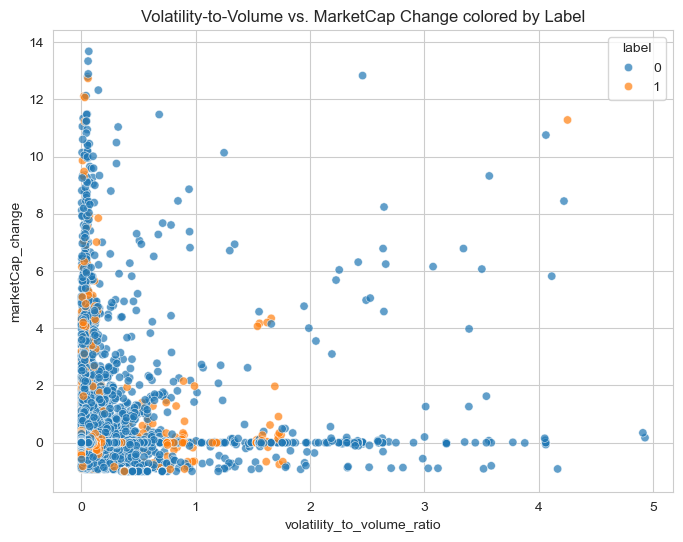

In [28]:
import seaborn as sns

df2 = df.sample(n=20000, random_state=42).copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='volatility_to_volume_ratio', y='marketCap_change', hue='label', alpha=0.7)
plt.title("Volatility-to-Volume vs. MarketCap Change colored by Label")
plt.show()


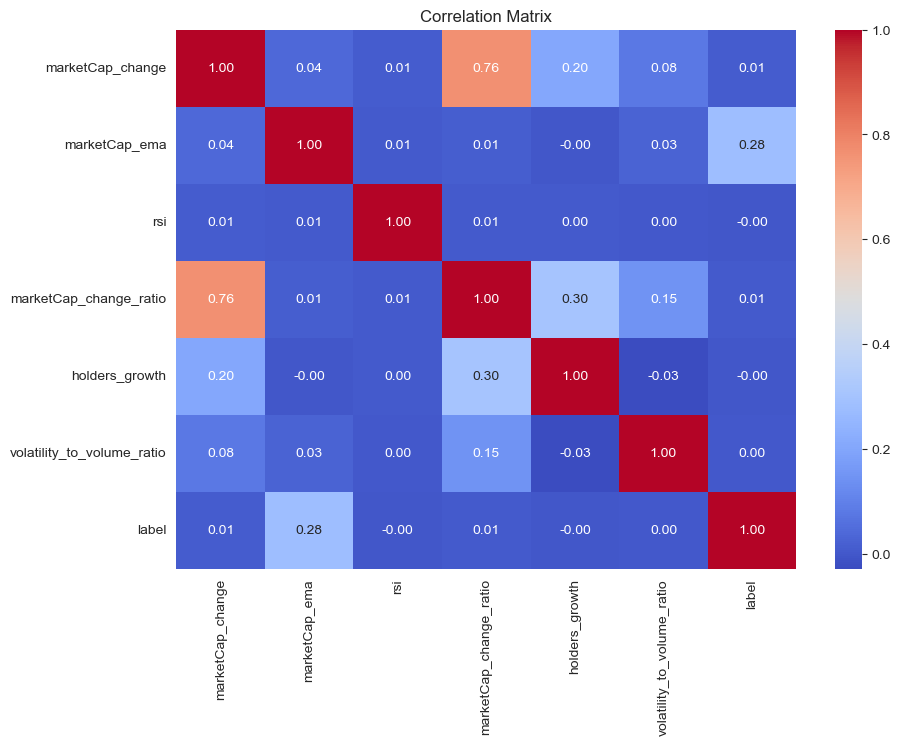

In [29]:
corr = df[features + ['label']].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()